In [85]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
%load_ext nengo.ipynb

from adder_env import create_adder_env
from constants import *
import logging
from random import shuffle

q_list = [(0,0,0,1), (0,0,1,0), (0,1,0,0), (1,0,0,0)]
ans_list = [(-1,1), (1,-1), (1,1), (-1,-1)]

The nengo.ipynb extension is already loaded. To reload it, use:
  %reload_ext nengo.ipynb


In [93]:
logging.basicConfig(filename='env.log',level=logging.DEBUG)

def create_adder_env(q_list, ans_list, op_val):
    with nengo.Network(label="env") as env:
        env.env_cls = AdderEnv(q_list, ans_list, op_val)

        env.get_ans = nengo.Node(env.env_cls.get_answer)
        env.set_ans = nengo.Node(env.env_cls.set_answer, size_in=D)
        env.env_keys = nengo.Node(env.env_cls.input_func)

        env.op_in = nengo.Node(env.env_cls.op_state_input)
        env.q_in = nengo.Node(env.env_cls.q_inputs)
        env.learning = nengo.Node(lambda t: env.env_cls.learning)
        env.gate = nengo.Node(lambda t: env.env_cls.gate)
    return env


class AdderEnv():

    def __init__(self, q_list, ans_list, op_val):
        ## Bunch of time constants
        self.rest = 0.05
        self.ans_duration = 0.3
        self.q_duration = 0.07
        self.op_duration = 0.05

        ## Value variables
        self.list_index = 0
        self.q_list = q_list
        self.ans_list = ans_list
        self.op_val = op_val
        self.num_items = len(q_list)
        self.indices = range(self.num_items)
        self.gate = 0

        ## Timing variables
        self.learning = False
        self.ans_arrive = 0.0
        self.time = 0.0
        self.chill = False

    def input_func(self, t):
        if self.time > self.rest:
            return self.q_list[self.indices[self.list_index]]
        else:
            return np.zeros(2*D)

    def q_inputs(self, t):
        if self.time > self.rest and self.time < (self.q_duration + self.rest):
            return self.q_list[self.indices[self.list_index]]
        else:
            return np.zeros(2*D)

    def op_state_input(self, t):
        if self.time > self.rest and self.time < (self.op_duration + self.rest):
            return self.op_val
        else:
            return np.zeros(len(self.op_val))

    def get_answer(self, t):
        if t < (self.ans_arrive + self.ans_duration) and self.ans_arrive != 0.0:
            return self.ans_list[self.indices[self.list_index]]
        else:
            return np.zeros(D)

    def set_answer(self, t, x):
        """Time keeping function.

        if there's some sort of answer coming from the basal-ganglia,
        detected by the norm not being (effectively) zero, give feedback for
        a certain amount of time before resetting the answer and starting the
        system again
        """
        self.time += dt

        mag = np.linalg.norm(x)

        # while getting answer
        if mag > 0.3 and not self.chill:

            if self.ans_arrive == 0.0:
                print("ANS %s" %t)
                # TODO: is this gate right?
                self.gate = 1
                self.ans_arrive = t
                self.learning = True
                # TODO: Make this check suck less
                if self.ans_list[self.indices[self.list_index]] != tuple(x):
                    logging.debug("%s != %s" %(self.ans_list[self.indices[self.list_index]], x))
            elif t > (self.ans_arrive + self.ans_duration):
                print("chill: %s" %t)
                self.ans_arrive = 0.0
                self.gate = 0
                self.chill = True
                self.learning = False

        elif mag < 0.3 and self.chill:
            print("stop chilling: %s" %t)
            
            if self.list_index < self.num_items - 1:
                self.list_index += 1
                print("after increment: %s \n" %self.list_index)
            else:
                shuffle(self.indices)
                self.list_index = 0


            self.chill = False
            self.time = 0.0

with nengo.Network(label="test") as model:
    env = create_adder_env(q_list, ans_list, (1,))

    # questions and op_state are given at the correct interval
    # and are swapped once an answer is given
    q_node = nengo.Node(size_in=D*2)
    op_node = nengo.Node(size_in=1)

    # input is given constantly throughout
    in_node = nengo.Node(size_in=D*2)

    def ans_func(t):
        if t < 0.1:
            return (0, 0)
        elif t < 0.45:
            return (-1,1)
        elif t < 0.6:
            return (0, 0)
        elif t < 0.95:
            return (1,-1)
        elif t < 1.0:
            return (0, 0)
        elif t < 1.35:
            return (1, 1)
        elif t < 1.8:
            return (0, 0)
        elif t < 2.15:
            return (-1, -1)
        elif t < 2.2:
            return (0, 0)
        elif t < 2.55:
            return ans_list[env.env_cls.list_index]
        elif t < 2.6:
            return (0, 0)
        elif t < 2.95:
            return ans_list[env.env_cls.list_index]
        else:
            return (0, 0)

    # answers can be given at different intervals
    ans_in = nengo.Node(ans_func)

    # the correct answer is returned
    ans_out = nengo.Node(size_in=D)

    # learning is maintained for a given interval
    learn_node = nengo.Node(size_in=1)

    # gate is '0' while waiting for answer
    gate_node = nengo.Node(size_in=1)

    nengo.Connection(env.q_in, q_node, synapse=None)
    nengo.Connection(env.op_in, op_node, synapse=None)
    nengo.Connection(env.env_keys, in_node, synapse=None)
    nengo.Connection(ans_in, env.set_ans, synapse=None)
    nengo.Connection(env.get_ans, ans_out, synapse=None)
    nengo.Connection(env.learning, learn_node, synapse=None)
    nengo.Connection(env.gate, gate_node, synapse=None)

    p_q = nengo.Probe(env.q_in, synapse=None)
    p_op = nengo.Probe(env.op_in, synapse=None)
    p_keys = nengo.Probe(env.env_keys, synapse=None)
    p_ans = nengo.Probe(env.get_ans, synapse=None)
    p_learn = nengo.Probe(env.learning, synapse=None)
    p_gate = nengo.Probe(env.gate, synapse=None)

    p_in = nengo.Probe(ans_in, synapse=None)

model

<Network "test" at 0x7f7cd7e7d990>

In [94]:
sim = nengo.Simulator(model, dt=dt)
sim.run(3.0)
t = sim.trange()

ANS 0.1
chill: 0.41
stop chilling: 0.45
after increment: 1 

ANS 0.6
chill: 0.9
stop chilling: 0.95
after increment: 2 

ANS 1.0
chill: 1.31
stop chilling: 1.35
after increment: 3 

ANS 1.8
chill: 2.11
stop chilling: 2.15
ANS 2.2
chill: 2.51
stop chilling: 2.55
after increment: 1 

ANS 2.6
chill: 2.91
stop chilling: 2.95
after increment: 2 



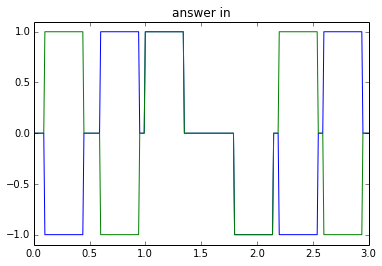

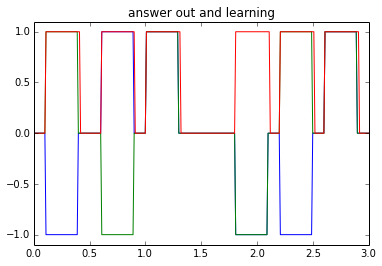

In [95]:
plt.figure()
plt.title("answer in")
plt.plot(t, sim.data[p_in])
plt.ylim(-1.1, 1.1)
plt.figure()
plt.title("answer out and learning")
plt.plot(t, sim.data[p_ans])
plt.ylim(-1.1, 1.1)
plt.plot(t, sim.data[p_learn])

(-1.1, 1.1)

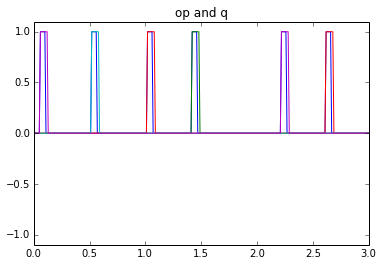

In [96]:
plt.figure()
plt.title("op and q")
plt.plot(t, sim.data[p_op])
plt.plot(t, sim.data[p_q])
plt.ylim(-1.1, 1.1)

(-1.1, 1.1)

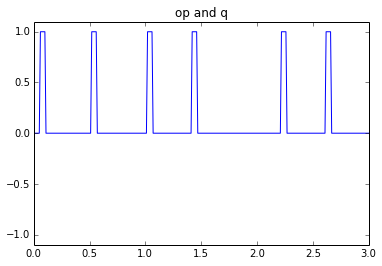

In [97]:
plt.figure()
plt.title("op and q")
plt.plot(t, sim.data[p_op])
plt.ylim(-1.1, 1.1)

(-1.1, 1.1)

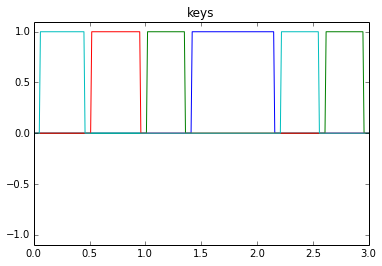

In [98]:
plt.figure()
plt.title("keys")
plt.plot(t, sim.data[p_keys])
plt.ylim(-1.1, 1.1)